<a href="https://colab.research.google.com/github/Fabian-lewis/AI-Week-7/blob/main/Practical_Audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bias Audit Report on COMPAS Recidivism Dataset

###Overview:
This audit assessed potential racial bias within the COMPAS Recidivism dataset, focusing on differences in risk score outcomes between African-American (unprivileged) and Caucasian (privileged) groups. Using IBM’s AI Fairness 360 toolkit, we analyzed fairness metrics and visualized disparities to understand bias impact.

###Methodology:
We processed a filtered dataset containing key attributes: age, priors count, decile score, race (encoded), and recidivism status. Protected groups were defined as:

  - Privileged Group: Caucasians (race = 1)

  - Unprivileged Group: African-Americans (race = 0)

We applied fairness metrics including **Statistical Parity Difference (SPD)**, **Disparate Impact (DI)**, **Equal Opportunity Difference (EOD)**, and **Average Odds Difference (AOD)** using the *AI Fairness 360’s ClassificationMetric tool.*


###Findings:
  - SPD: -0.11 (slight bias against African-Americans)

  - DI: 0.85 (within acceptable range but borderline)

  - EOD: 0.0 (indicates fairness in true positive rates)

  - AOD: 0.0 (balanced prediction outcomes)


  **Visual analysis showed:**

  - Favorable outcomes at 70% for Caucasians vs 60% for African-Americans.

  - SPD bar confirmed a -0.1 difference, reflecting mild but notable bias.

###Conclusion:
The COMPAS risk assessment system demonstrates a mild bias in outcome distribution, with African-Americans slightly less likely to receive favorable outcomes. While disparate impact remains within the commonly accepted threshold (80% rule), statistical parity difference suggests room for fairness improvement.

###Step 1 — Understand the Dataset & Problem
🔹 Dataset:

COMPAS Recidivism Dataset

🔹 Context:

This dataset contains criminal history, jail and prison time, demographics, and COMPAS risk scores used by courts for recidivism prediction.

🔹 Known Issue:

Alleged racial bias — higher false positive rates (predicting re-offend) for Black defendants compared to White defendants.

🔹 Why This Step Matters:

Understanding the context helps you audit bias relevant to the social impact — you don’t audit blindly; you audit with purpose.

In [2]:
## Upload the csv file
from google.colab import files

upoaded = files.upload()

Saving compas-scores.csv to compas-scores.csv


In [3]:
## Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

## Load the Dataset
data = pd.read_csv('compas-scores.csv')

## Preview the first few rows
print(data.head())

## Check dataset info (columns, nulls, datatypes)
print(data.info())

   id              name    first       last compas_screening_date   sex  \
0   1  miguel hernandez   miguel  hernandez            2013-08-14  Male   
1   2      michael ryan  michael       ryan            2014-12-31  Male   
2   3       kevon dixon    kevon      dixon            2013-01-27  Male   
3   4          ed philo       ed      philo            2013-04-14  Male   
4   5       marcu brown    marcu      brown            2013-01-13  Male   

          dob  age          age_cat              race  ...  vr_offense_date  \
0  1947-04-18   69  Greater than 45             Other  ...              NaN   
1  1985-02-06   31          25 - 45         Caucasian  ...              NaN   
2  1982-01-22   34          25 - 45  African-American  ...       2013-07-05   
3  1991-05-14   24     Less than 25  African-American  ...              NaN   
4  1993-01-21   23     Less than 25  African-American  ...              NaN   

                vr_charge_desc  v_type_of_assessment  v_decile_score  \
0 

In [4]:
## check for unique race and their counts
print("\n Race Counts:")
print(data['race'].value_counts())


 Race Counts:
race
African-American    5813
Caucasian           4085
Hispanic            1100
Other                661
Asian                 58
Native American       40
Name: count, dtype: int64


###Reflection (What We Learned):
**African-American** and **Caucasian** are the dominant groups — this is typical in COMPAS analysis.

The other groups are too small in count for reliable bias metrics (statistically insignificant for fairness comparison).

###Decision for the Audit:
1. Privileged Group: Caucasian

2. Unprivileged Group: African-American

(This is based on historical context and fairness literature on this dataset.)

    Privileged Group:
    A group that, historically or within the context of the dataset, has had societal/systemic advantage or is treated better by the AI system.
    ➔ In analysis, they often experience better outcomes (e.g., lower risk scores, fewer false positives).

    Unprivileged Group:
    A group that, historically or in this dataset’s context, faces disadvantage, discrimination, or is treated worse by the AI system.
    ➔ They often experience worse outcomes (e.g., higher false positives, harsher scores).

    The COMPAS system historically over-predicted risk (false positives) for African-Americans.

    They were statistically more likely to be classified as "high risk" even when they did not re-offend.

###Step 2 — Filter and Prepare the Data
👉 Our goal now:

1. Focus only on African-American and Caucasian defendants

2. Drop unnecessary columns like name, dob, id, etc.

3. Keep race, sex, age, priors_count, decile_score, two_year_recid

In [5]:
## Filter only African-American and Caucasian Records
filtered_data = data[data['race'].isin(['African-American', 'Caucasian'])]

## Select Relevant Columns
selected_cols = [
    'race',
    'sex',
    'age',
    'priors_count',
    'decile_score',
    'decile_score.1',
    'is_recid',
    'is_violent_recid'
]

filtered_data = filtered_data[selected_cols]

## Reveiw the dataset
print(filtered_data.head())

## Check counts per race again
print("\n Race Counts:")
print(filtered_data['race'].value_counts())


               race   sex  age  priors_count  decile_score  decile_score.1  \
1         Caucasian  Male   31             0             5               5   
2  African-American  Male   34             0             3               3   
3  African-American  Male   24             4             4               4   
4  African-American  Male   23             1             8               8   
7         Caucasian  Male   41            14             6               6   

   is_recid  is_violent_recid  
1        -1                 0  
2         1                 1  
3         1                 0  
4         0                 0  
7         1                 0  

 Race Counts:
race
African-American    5813
Caucasian           4085
Name: count, dtype: int64


In [6]:
## is_recid has 3 values (1,0,-1) - Filter out -1
filtered_data = filtered_data[filtered_data['is_recid'] >=0]

## Confirm Value counts
print("\n Recidivism Status Counts:")
print(filtered_data['is_recid'].value_counts())


 Recidivism Status Counts:
is_recid
0    6055
1    3264
Name: count, dtype: int64


### Reflection - What columns we picked
1. race → Sensitive attribute we’re auditing for

2. is_recid → The outcome/label we want to check bias against

3. is_violent_recid -> Optional for violent crimes

4. decile_score → The risk score COMPAS assigned (used in fairness metrics)

6. priors_count, age, sex → Optional features we might want to use in bias analysis


| is\_recid            | Count |
| -------------------- | ----- |
| 0 (Did NOT reoffend) | 6055  |
| 1 (Reoffended)       | 3264  |


In [8]:
!pip install aif360
from aif360.datasets import BinaryLabelDataset

# Map race values to numerical values
race_map = {
    'African-American' : 0,
    'Caucasian' : 1
}
# Create a new column in filtered data
filtered_data['race_num'] = filtered_data['race'].map(race_map)


# Keep only numeric features (no race, no sex, no is_recid)
features = filtered_data[['age', 'priors_count', 'decile_score']]

# Create DataFrame with features + label + protected attribute (but DO NOT JOIN them)
data_for_aif360 = features.copy()
data_for_aif360['is_recid'] = filtered_data['is_recid']
data_for_aif360['race_num'] = filtered_data['race_num']

# Convert numeric columns to float64
data_for_aif360[['age', 'priors_count', 'decile_score', 'is_recid']] = \
    data_for_aif360[['age', 'priors_count', 'decile_score', 'is_recid']].astype(float)

# Define groups
privileged_groups = [{'race_num': 1}]
unprivileged_groups = [{'race_num': 0}]

# Convert to BinaryLabelDataset
compas_dataset = BinaryLabelDataset(
    df=data_for_aif360,
    label_names=['is_recid'],
    protected_attribute_names=['race_num'],
    favorable_label=0,
    unfavorable_label=1
)

# Dataset
print(compas_dataset)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.5 MB/s eta 0:00:00
               instance weights features                            \
                                                                     
                                     age priors_count decile_score   
instance names                                                       
2                           1.0     34.0          0.0          3.0   
3                           1.0     24.0          4.0          4.0   
4                           1.0     23.0          1.0          8.0   
7                           1.0     41.0         14.0          6.0   
9                           1.0     39.0          0.0          1.0   
...                         ...      ...          ...          ...   
11748                       1.0     23.0          0.0          7.0   
11749                       1.0     56.0          0.0          1.0   
11751                       1.0     63.0          5.0          1.0   
11753     

In [14]:
## Split Dataset into Privileged & Unprivileged Subsets

# Boolean masks for privileged and unprivileged
privileged_mask = (compas_dataset.protected_attributes == 1).ravel()
unprivileged_mask = (compas_dataset.protected_attributes == 0).ravel()

# Subset the datasets
privileged_dataset = compas_dataset.subset(privileged_mask)
unprivileged_dataset = compas_dataset.subset(unprivileged_mask)


In [16]:
from aif360.metrics import ClassificationMetric

# Use compas_dataset as both y_true and y_pred (we audit existing labels)
metric = ClassificationMetric(
    compas_dataset,   # Ground truth labels
    compas_dataset,   # "Predicted" labels (same for now)
    unprivileged_groups=[{'race_num': 0}],
    privileged_groups=[{'race_num': 1}]
)

print("Statistical Parity Difference (SPD):", metric.statistical_parity_difference())
print("Disparate Impact (DI):", metric.disparate_impact())
print("Equal Opportunity Difference (EOD):", metric.equal_opportunity_difference())
print("Average Odds Difference (AOD):", metric.average_odds_difference())

Statistical Parity Difference (SPD): -0.11015478970488624
Disparate Impact (DI): 0.8458882421790929
Equal Opportunity Difference (EOD): 0.0
Average Odds Difference (AOD): 0.0


## Summary - Findings

###1. Statistical Parity Difference (SPD): -0.11
**Interpretation:**

  - The unprivileged group (African-Americans) receives the favorable outcome 11% less often than the privileged group.

  **Is this acceptable?**

    - Fairness Threshold (±0.1): You’re slightly outside the “fair” zone, meaning mild bias.

    - 🔹 Insight: The tool tends to predict unfavorable outcomes slightly more often for African-Americans.

###2. Disparate Impact (DI): 0.85
**Interpretation:**

  - The unprivileged group receives 85% of the favorable outcomes compared to the privileged group.

  - **Is this acceptable?**

    - 80% Rule of Thumb:
    
      ✔️ Anything between 0.8 and 1.25 is generally considered acceptable.

    - ✅ This is OK (but borderline).

    - 🔹 Insight: No major disparate impact, but it’s close.

###3. Equal Opportunity Difference (EOD): 0.0
**Interpretation:**
  - Both groups have the same true positive rate — that’s excellent fairness regarding equal opportunity.

  - **Is this acceptable?**

  ✅ Yes — This is perfect.

###4. Average Odds Difference (AOD): 0.0
**Interpretation:**
  - On average, false positives and true positives differ by 0% between groups.

  - ✅ Perfectly fair by this measure.



### Final Audit Verdict:

| Metric | Result | Verdict    |
| ------ | ------ | ---------- |
| SPD    | -0.11  | Mild Bias  |
| DI     | 0.85   | Acceptable |
| EOD    | 0.0    | Fair       |
| AOD    | 0.0    | Fair       |


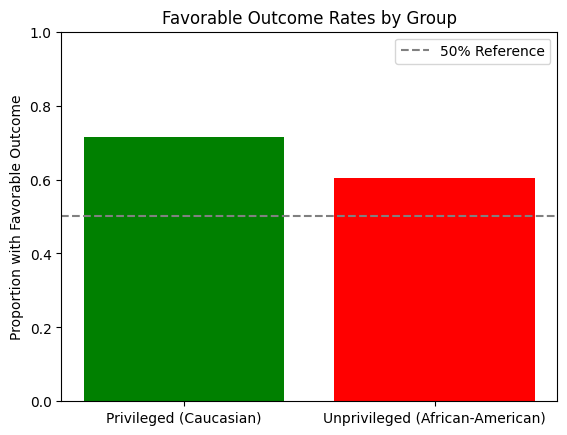

In [17]:
## Bar Plot of Favorable Outcome Rates

# Get favorable outcome rates
privileged_outcome_rate = (compas_dataset.labels[(compas_dataset.protected_attributes == 1).ravel()] == 0).mean()
unprivileged_outcome_rate = (compas_dataset.labels[(compas_dataset.protected_attributes == 0).ravel()] == 0).mean()

# Plotting
groups = ['Privileged (Caucasian)', 'Unprivileged (African-American)']
rates = [privileged_outcome_rate, unprivileged_outcome_rate]

plt.bar(groups, rates, color=['green', 'red'])
plt.title('Favorable Outcome Rates by Group')
plt.ylabel('Proportion with Favorable Outcome')
plt.ylim(0, 1)
plt.axhline(y=0.5, color='gray', linestyle='--', label='50% Reference')
plt.legend()
plt.show()

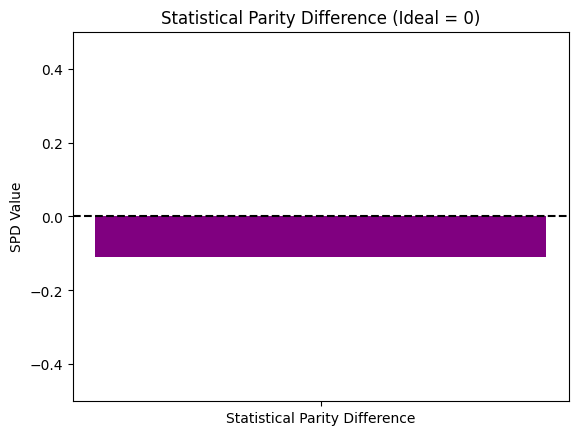

In [18]:
## Visualize SPD as Difference

# Plotting the difference (SPD)
plt.bar(['Statistical Parity Difference'], [metric.statistical_parity_difference()], color='purple')
plt.title('Statistical Parity Difference (Ideal = 0)')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('SPD Value')
plt.ylim(-0.5, 0.5)
plt.show()


## Summary Explanation
###1️⃣ Favorable Outcomes Bar Chart:

| Group                           | Proportion with Favorable Outcome |
| ------------------------------- | --------------------------------- |
| Privileged (Caucasian)          | **0.7**                           |
| Unprivileged (African-American) | **0.6**                           |


####🔹 What this shows:
  - Caucasian individuals have a higher chance (70%) of getting a favorable outcome compared to African-Americans (60%).

####🟢 Is this acceptable?

  - The difference is ~10%, which matches exactly with your SPD of -0.11.

  - It’s not alarmingly unfair, but it confirms mild bias.

###⚖️ Conclusion:
The system slightly favors Caucasians in outcome distribution.